In [1]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

sys.path.append('/user_data/mmhender/imStat/code/')
import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [15]:
# Load results of the fitting procedure

subject = 5
volume_space=True
# fitting_type = 'alexnet_Conv5'
fitting_type = 'alexnet_all_conv_pca'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

IndexError: list index out of range

In [9]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [16]:
port=33333
summary_plots.plot_summary_pycortex(out=out, subject=subject, fitting_type=fitting_type, \
                                port=port, roi_def=roi_def)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333
Stopping server


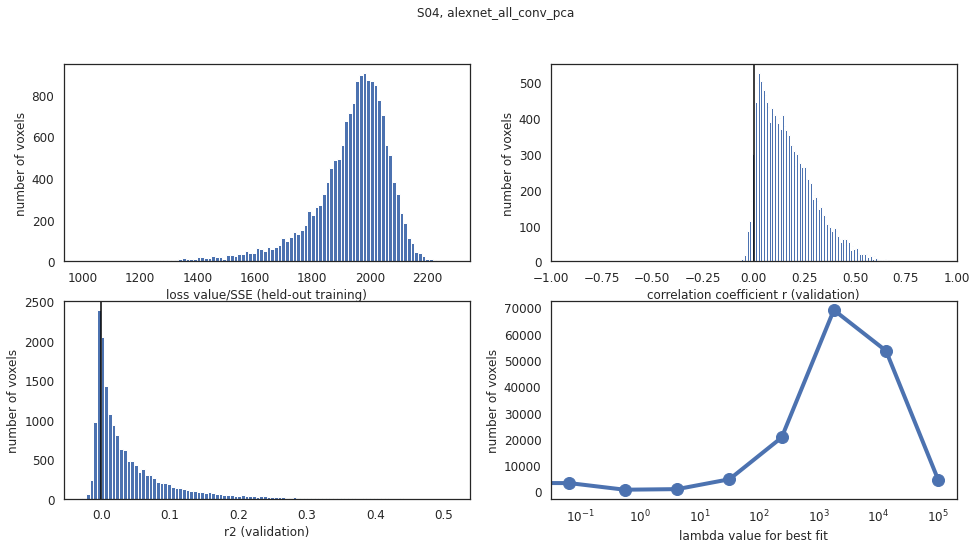

In [10]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

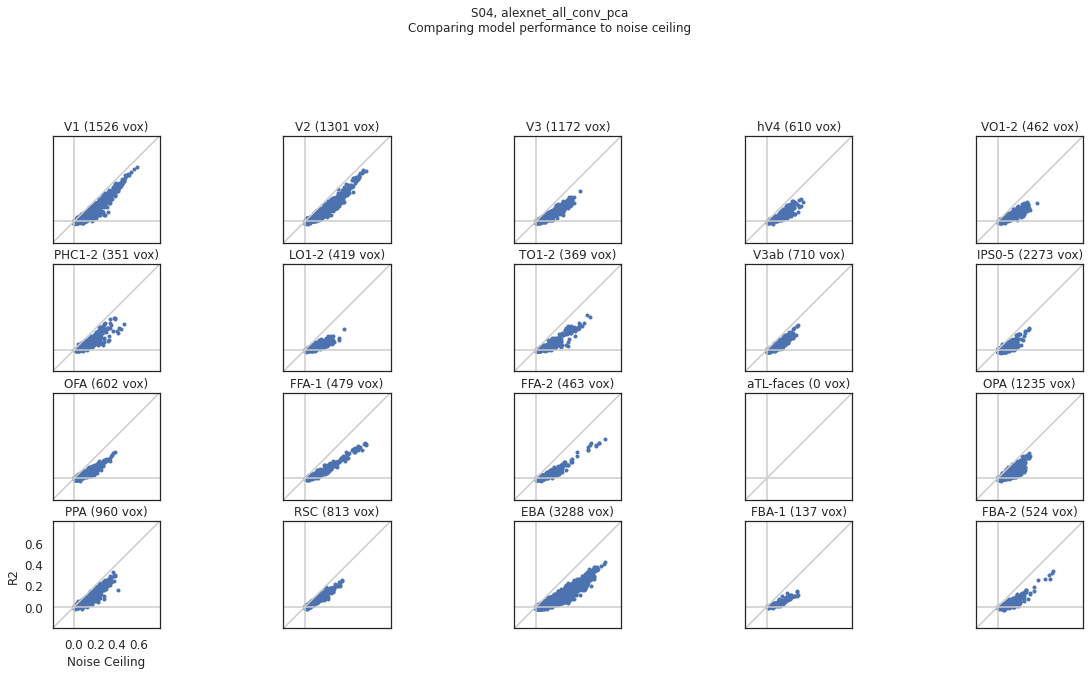

In [11]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_r2_vs_nc(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                            fig_save_folder=fig_save_folder,axlims = [-0.2, 0.8])

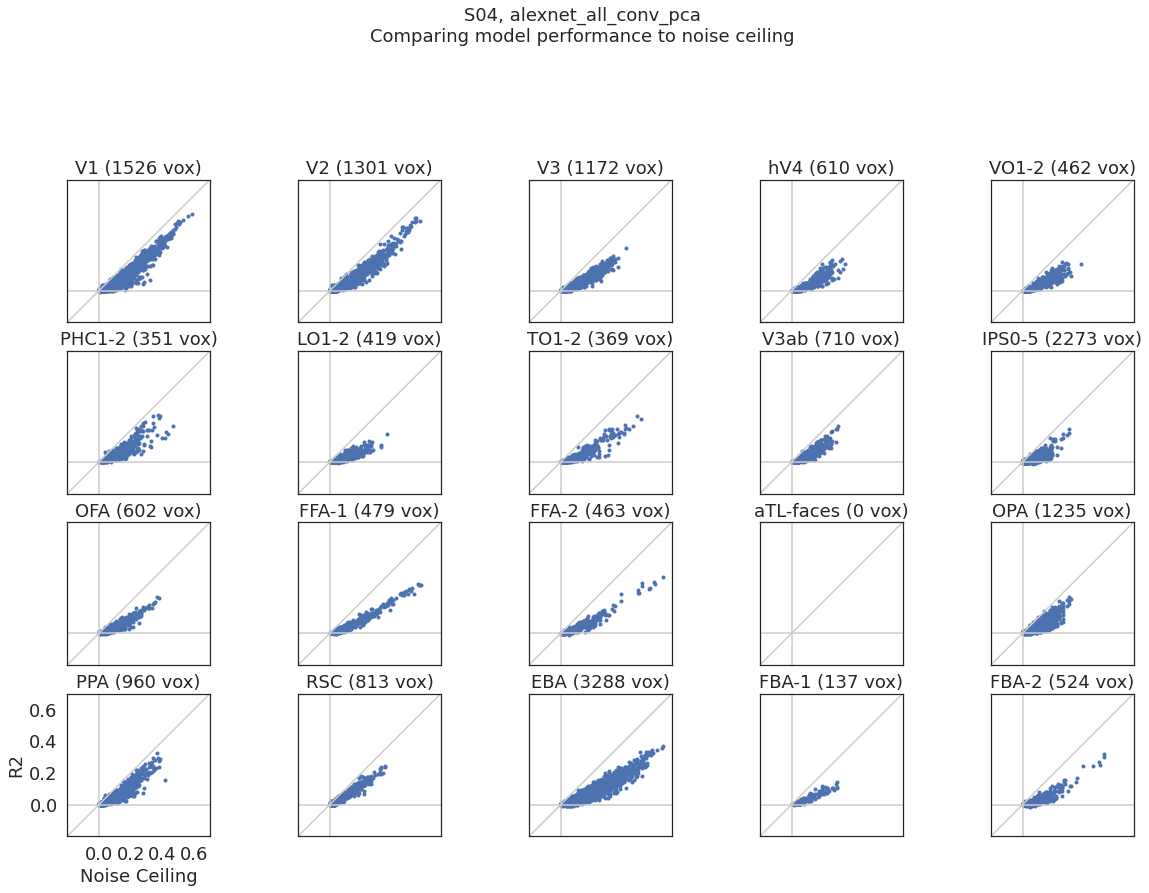

In [12]:
# Plot best single layer only

from utils import nsd_utils
plot_utils.set_all_font_sizes(fs = 18)
fig_size=(20,24)
voxel_ncsnr = out['voxel_ncsnr'].ravel()[out['voxel_index'][0]]
noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100

single_layer_inds = [1,3,5,7,9]
best_layer = (np.argmax(out['val_r2'][:,single_layer_inds], axis=1)).astype('int')
val_r2 = np.array([out['val_r2'][vv,single_layer_inds[best_layer[vv]]] for vv in range(len(best_layer))])


inds2use = np.ones(np.shape(val_r2))==1

sp = plot_utils.scatter_plot(color=None, xlabel='Noise Ceiling', ylabel='R2', xlims=[-0.2, 0.7], ylims=[-0.2, 0.7], \
                  xticks=[0, 0.2, 0.4, 0.6], yticks=[0, 0.2, 0.4, 0.6],\
                                                        show_diagonal=True, show_axes=True);

if fig_size is None:
    fig_size = (20,18)
plot_utils.create_roi_subplots(np.concatenate([noise_ceiling[:,np.newaxis],val_r2[:,np.newaxis]], axis=1), inds2use, sp, subject, out,\
                    suptitle='S%02d, %s\nComparing model performance to noise ceiling'%(subject, fitting_type), \
                   label_just_corner=True, figsize=fig_size, roi_def=roi_def, skip_inds=skip_inds)
plt.gcf().subplots_adjust(bottom=0.5)
# if fig_save_folder is not None:
#     plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.png'))
#     plt.savefig(os.path.join(fig_save_folder,'r2_STonly_vs_noiseceiling.pdf'))


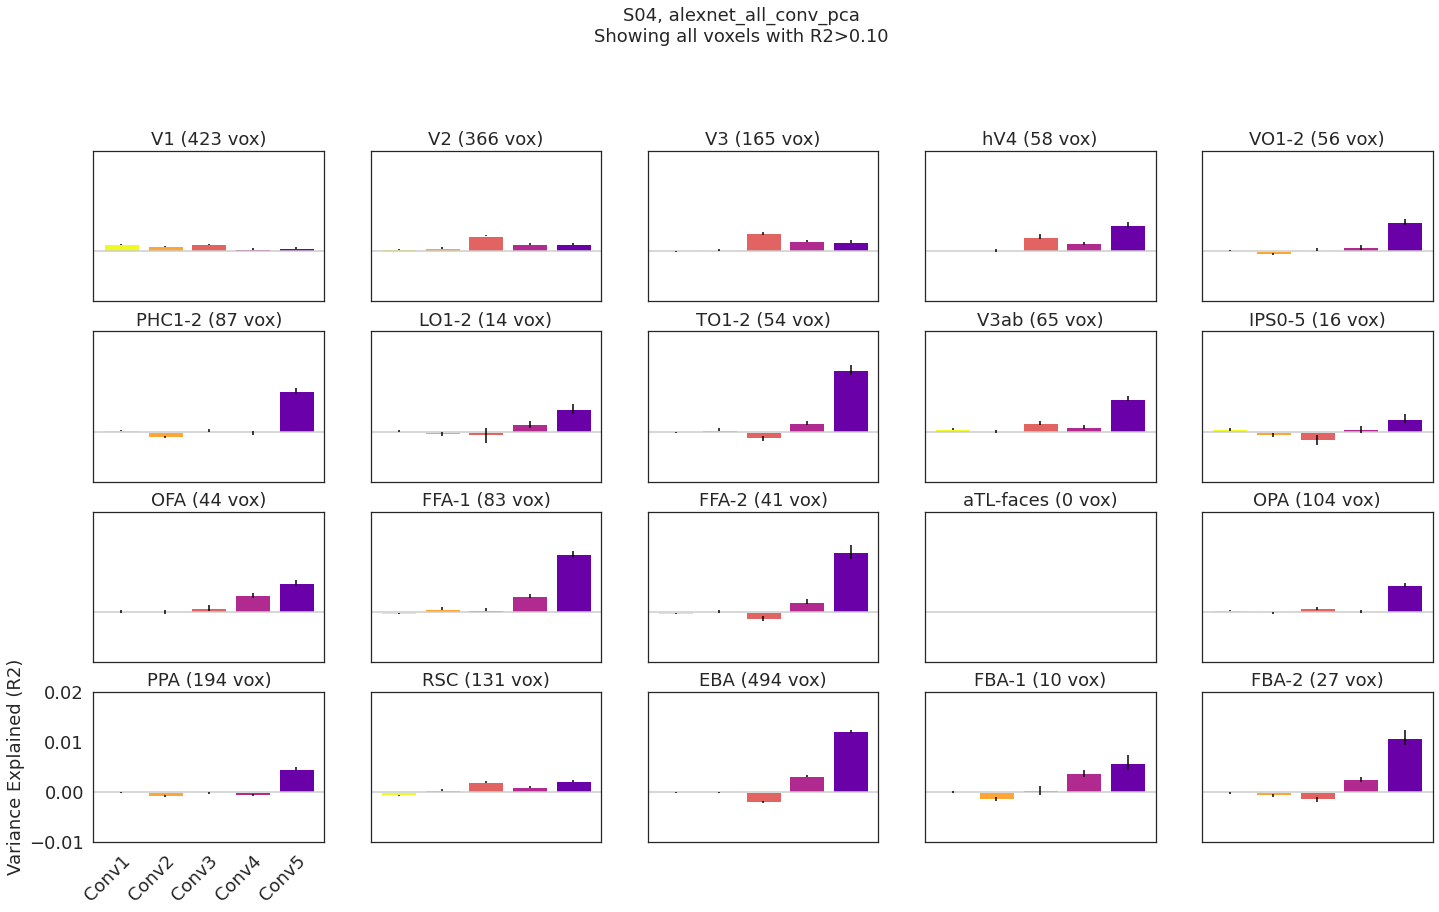

In [13]:
ve_names = ['Conv%d'%(ll+1) for ll in range(5)]
var_expl = np.tile(out['val_r2'][:,0:1], [1,5]) - out['val_r2'][:,[2,4,6,8,10]]

colors = cm.plasma(np.linspace(0,1,6))
colors = np.flipud(colors)

r2_thresh = 0.10
inds2use = out['val_r2'][:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.02])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels with R2>%.2f'%(subject, fitting_type, r2_thresh))
plt.gcf().subplots_adjust(bottom=0.4)


In [9]:

port=63333

vox2plot = (out['val_r2'][:,0]>0)

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)', \
        'R2 concat']
maps = [best_ecc_deg, best_angle_deg, best_size_deg, np.sqrt(out['val_r2'][:,0])]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn', 'PuBu']
mins = [0,0,0, 0]
maxes = [7, 360, 4, 0.8]

names +=['R2 Conv%s alone'%(ll+1) for ll in range(5)]
maps +=[np.sqrt(out['val_r2'][:,pp]) for pp in [1,3,5,7,9]]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0,0]
maxes += [0.8, 0.8, 0.8, 0.8, 0.8]

best_layer = (np.argmax(out['val_r2'][:,[1,3,5,7,9]], axis=1)+1).astype(np.float32)
maps += [best_layer]
names += ['Best conv layer (individual R2)']
cmaps += ['plasma_r']
mins += [0]
maxes += [5]

names += ['Unique: Conv%d'%(ll+1) for ll in range(5)]
var_expl = np.tile(out['val_r2'][:,0:1], [1,5]) - out['val_r2'][:,[2,4,6,8,10]]
maps += [np.sqrt(var_expl[:,ll]) for ll in range(5)]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'PuBu']
mins += [0,0,0,0,0]
maxes += [0.2, 0.2, 0.2, 0.2, 0.2]

best_layer = (np.argmax(var_expl, axis=1)+1).astype(np.float32)
maps += [best_layer]
names += ['Best conv layer (unique var expl)']
cmaps += ['plasma_r']
mins += [0]
maxes += [5]
plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:63333
Started server on port 63333


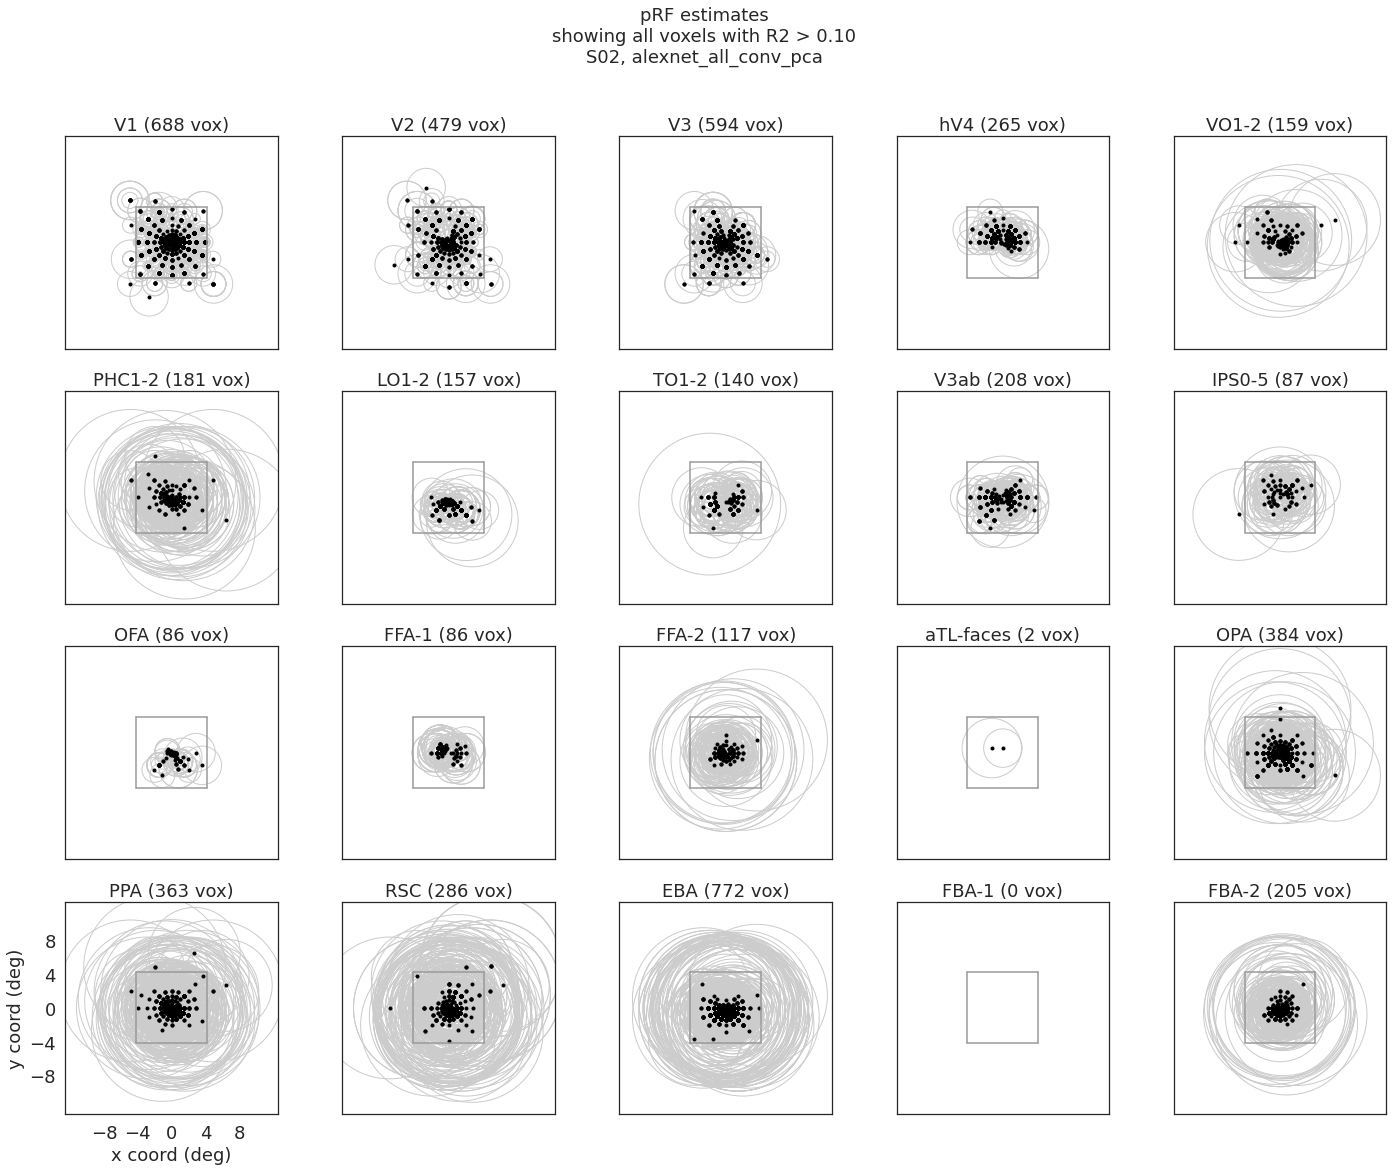

In [10]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_spatial_rf_circles(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds,\
                                     r2_cutoff = 0.10, fig_save_folder=fig_save_folder)

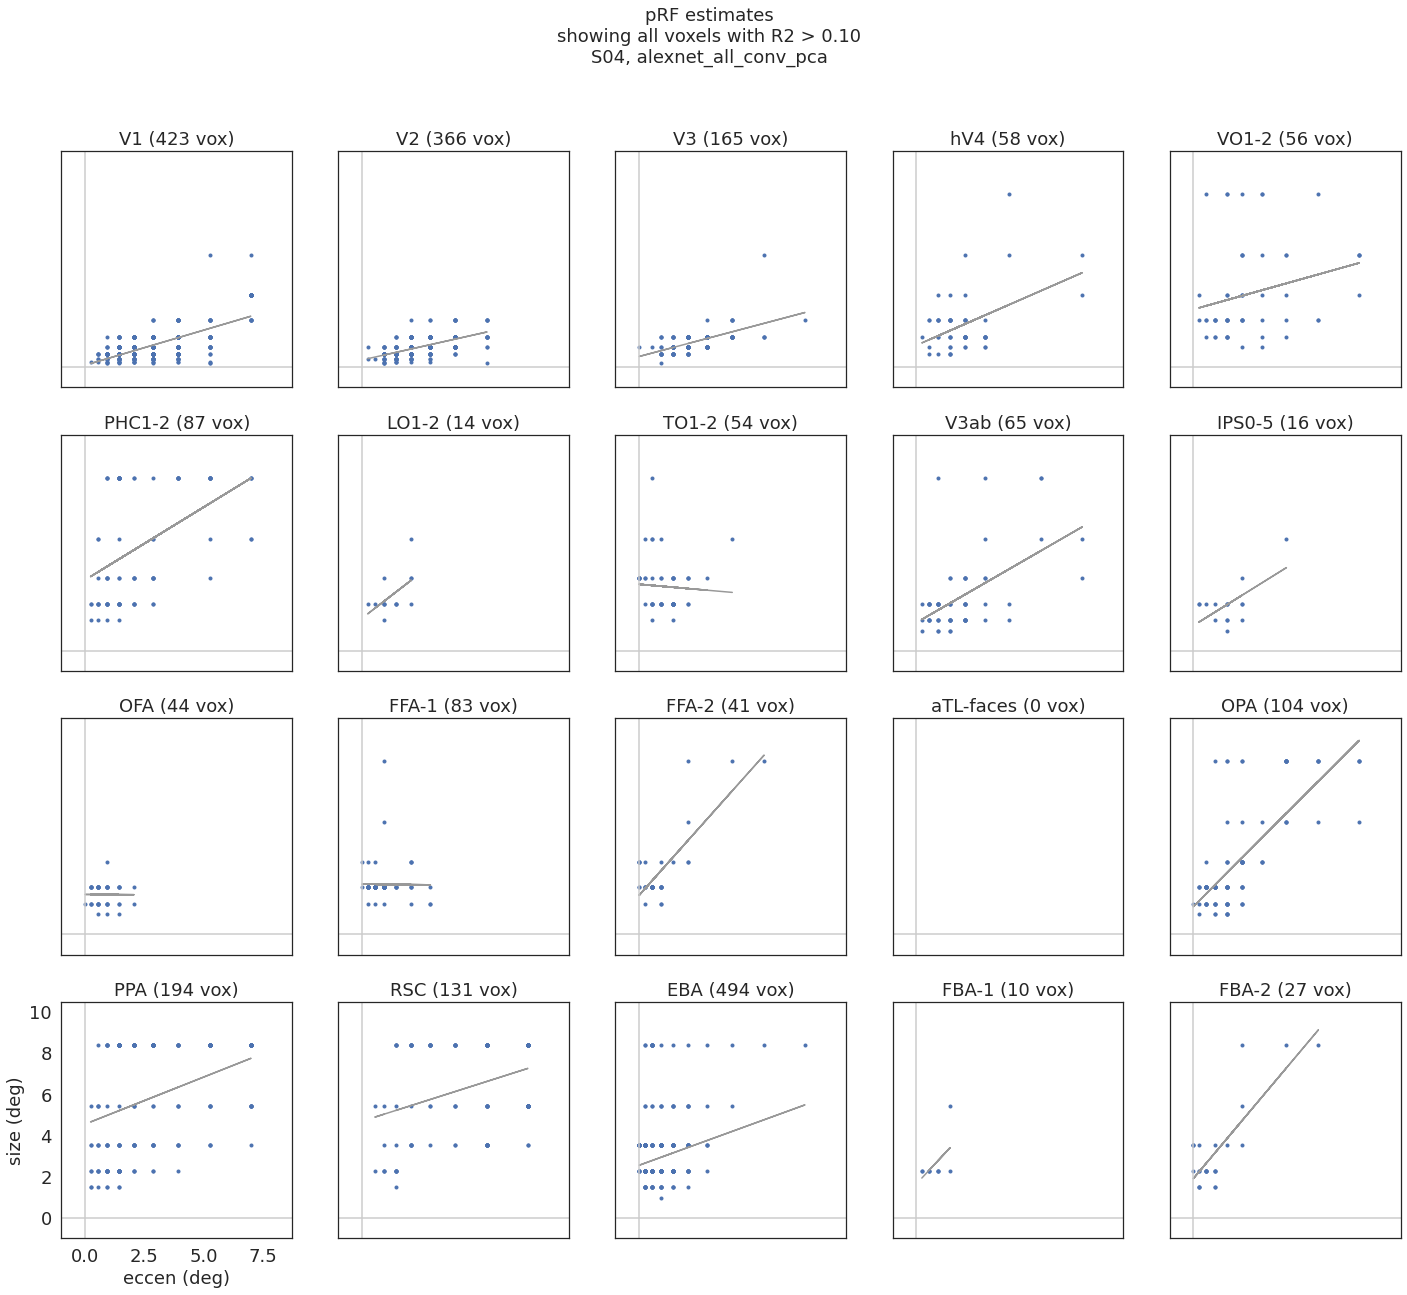

In [14]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_size_vs_eccen(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                                   r2_cutoff=0.10, fig_save_folder=fig_save_folder)

In [13]:
nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


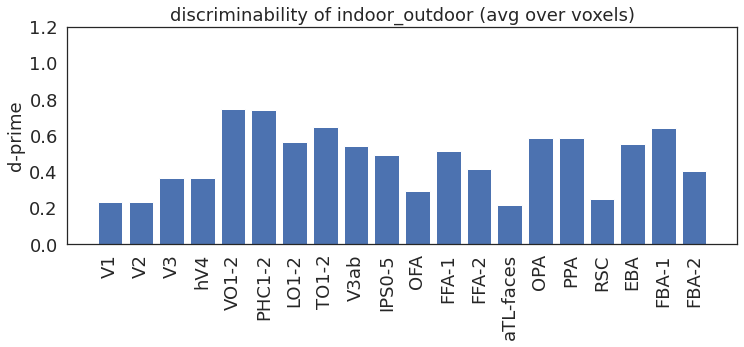

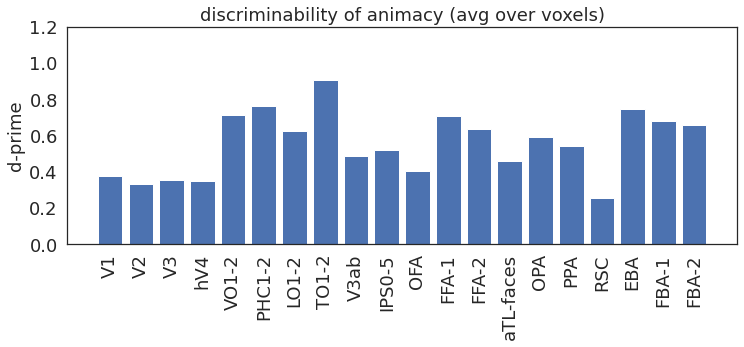

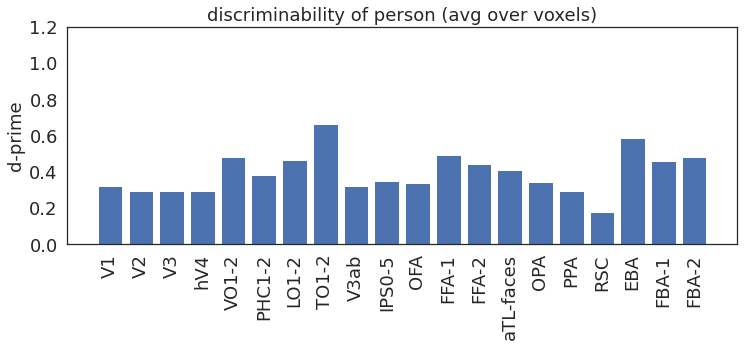

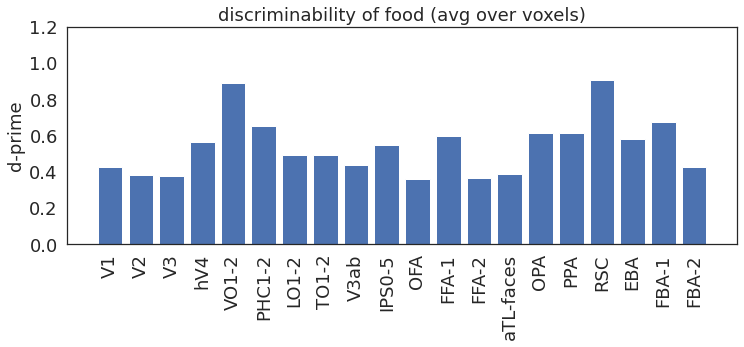

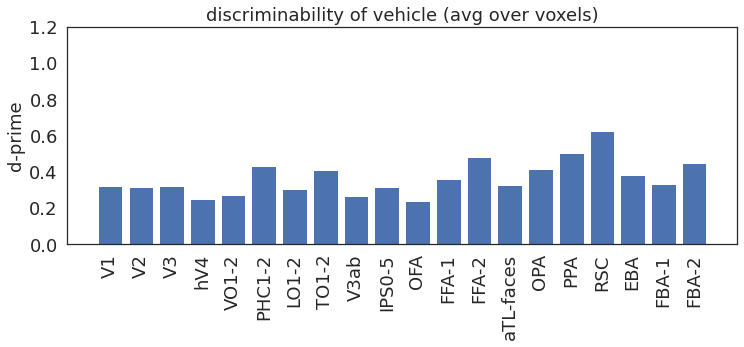

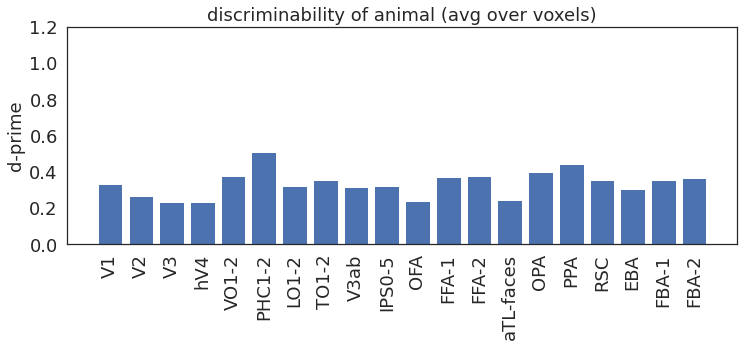

In [14]:
discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((n_rois, n_sem_axes))

for rr in range(n_rois):
    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
        mean_discrim_each_roi[rr,:] = np.mean(np.abs(discrim_each_axis[inds_this_roi,:]), axis=0)
    else:
        mean_discrim_each_roi[rr,:] = np.nan


for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    plt.bar(np.arange(n_rois_plot),mean_discrim_each_roi[inds2use,aa])
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,1.2])